---
title:  "Principal Component Analysis Using Python"
excerpt: "python 으로 하는 주성분 분석(PCA)"

categories:
  - Machine-Learning
tags:
  - PCA
  - EigenDecomposition
  - Dimension reduction
  - Feature extraction
last_modified_at: 2020-04-26T21:15:00-05:00
---

## Principal component analysis  
### reference  
- PCA 개념관련_01 : https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/04/06/pcasvdlsa/
- PCA 개념관련_02 : https://darkpgmr.tistory.com/104
- 코드관련 : StatQuest youtube - "PCA in Python" 을 참고하여 진행했다
- 포아송분포관련 blog : https://blog.naver.com/PostView.nhn?blogId=mykepzzang&logNo=220840724901

## Loding Library

In [2]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt # NOTE: This was tested with matplotlib v. 2.1.0

## Data Generation Code

In [4]:
## In this example, the data is in a data frame called data.
## Columns are individual samples (i.e. cells)
## Rows are measurements taken for all the samples (i.e. genes)
## Just for the sake of the example, we'll use made up data...
genes = ['gene' + str(i) for i in range(1,101)]
 
wt = ['wt' + str(i) for i in range(1,6)]
ko = ['ko' + str(i) for i in range(1,6)]
 
data = pd.DataFrame(columns=[*wt, *ko], index=genes)
 
for gene in data.index:
    data.loc[gene,'wt1':'wt5'] = np.random.poisson(lam=rd.randrange(10,1000), size=5)
    data.loc[gene,'ko1':'ko5'] = np.random.poisson(lam=rd.randrange(10,1000), size=5)

## Special Poisson Distribution
random.poisson 은 lam 다 값을 통하여, 랜덤하게 값을 뽑는데, 이때 lambda의 범위를 10 ~ 1000 으로 한다.  
이걸 활용하여, 이 lambda 값을 활용하여, 포아송 분포에서, 랜덤하게 5(size=5)개를 추출한다. 

In [5]:
# ![img](../dataset/PCA/1280px-Poisson_pmf.svg.PNG)

In [6]:
import seaborn as sns
sns.set(style="darkgrid", palette="muted", color_codes=True)
%matplotlib inline

#### 포아송분포 정의  
1) 모수 : 모집단의 특성을 나타내는 수치  ex> 한 시간동안 사무실에 걸려온 전화의 수, 일주일동안 기병들이 낙마하는 횟수  
2) 포아송분포의 모수 : "단위시간 또는 단위공간에서 평균발생횟수"  

정의하면, __"단위 시간, 단위 공간에 어떤 사건이 몇 번 발생할 것인가를 표현하는 이산 확률분포"__

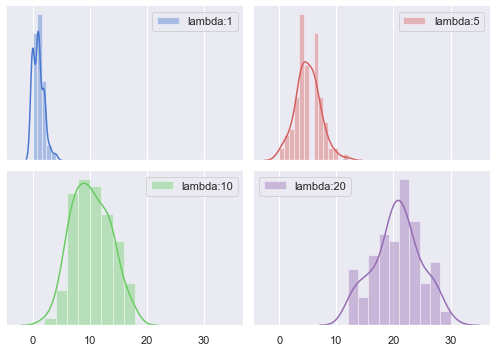

In [7]:
# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(7, 5), sharex=True)
sns.despine(left=True)

ax1=sns.distplot(np.random.poisson(lam=1, size=100), color="b", kde=True, ax=axes[0, 0],label="lambda:1")
ax1.legend()
ax2=sns.distplot(np.random.poisson(lam=5, size=100), color="r", kde=True, ax=axes[0, 1],label="lambda:5")
ax2.legend()
ax3=sns.distplot(np.random.poisson(lam=10, size=100), color="g", kde=True, ax=axes[1, 0],label="lambda:10")
ax3.legend()
ax4=sns.distplot(np.random.poisson(lam=20, size=100), color="m", kde=True, ax=axes[1, 1],label="lambda:20")
ax4.legend()

plt.setp(axes, yticks=[])
plt.tight_layout()

In [8]:
print(data.head()) ## gene 이 feature고, wt1~5,ko1~5 가 sample이다.
print()
print(data.shape)

       wt1  wt2  wt3  wt4  wt5  ko1  ko2  ko3  ko4  ko5
gene1  439  446  452  436  425  200  207  184  197  191
gene2  125  152  130  114  118  883  885  898  887  882
gene3  432  466  452  484  469  382  434  414  428  437
gene4  252  269  247  246  238  596  596  579  608  619
gene5  709  659  671  663  678   53   67   49   53   50

(100, 10)


In [9]:
## 데이터 형식을 익숙하게 row * feature 구조로 바꾼다
data01 = data.T
print(data01.shape)

(10, 100)


In [10]:
data01.head()

gene1 gene2 gene3 gene4 gene5 gene6 gene7 gene8 gene9 gene10  ... gene91  \
wt1   439   125   432   252   709   806   360    12   244    120  ...    213   
wt2   446   152   466   269   659   846   354    19   236     89  ...    212   
wt3   452   130   452   247   671   873   349    16   232    102  ...    205   
wt4   436   114   484   246   663   902   352    14   231    135  ...    192   
wt5   425   118   469   238   678   899   349    21   234    102  ...    214   

    gene92 gene93 gene94 gene95 gene96 gene97 gene98 gene99 gene100  
wt1    121    131    524    883    483    580    283    157     124  
wt2    118    138    525    896    457    539    265    154     127  
wt3    106    126    519    854    476    549    271    168     143  
wt4    104    113    531    885    469    565    277    153     147  
wt5    139    139    562    872    479    551    242    146     138  

[5 rows x 100 columns]

In [11]:
import warnings
warnings.filterwarnings(action='ignore')

#### 토막상식
[공분산행렬 유도 상세](https://ratsgo.github.io/linear%20algebra/2017/03/14/operations/)

## 공분산(Covariance) 와 상관계수(Correlation) 관계  
변수가 여러개인 다변량데이터에선 변수 간 관련성, 즉 상관성(correlation) 이 매우 중요하다.  
확률변수X의 값이 X의 평균보다 클때, Y의 값도  Y의 평균보다 커지고, X의 값이 X의 평균보다 작을때에는 Y의 값도 Y의 평균보다 작아지는 경향이 있으면 표준화된 X와Y의 곱인 상관계수(correlation coefficietnt)는 양의 값을 가질 가능성이 크다. 쉽게 표현하면, 두 확률변수의 직선관계가 얼마나 강하고, 어떤방향인지를 나타내는 값이라고 볼 수 있다.  

확률변수 X와 Y의 상관계수와 공분산은 다음과 같이 정의되는데  **공분산을 X,Y의 표준편차로 나누어 표준화한 값이 X와 Y의 상관관게라 할 수 있다.**  
(N=데이터 개수, u1=X의 평균, u2=Y의 평균, s1=X의 표준편차, s2=Y의 표준편차)

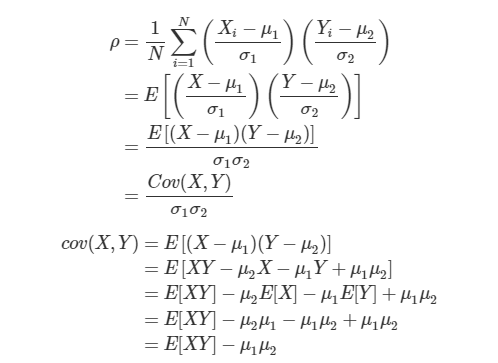

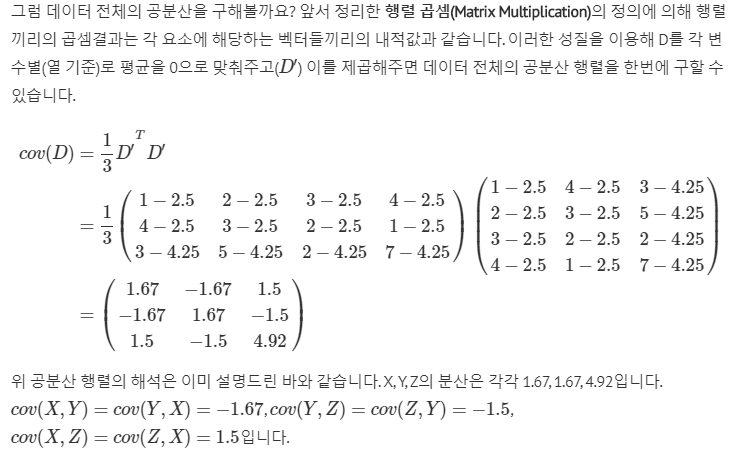

## Perform PCA on the data

센터화 + scaling 하는 부분은 어떤 library를 사용해도 상관없다.

In [12]:
# First center and scale the data
sc = preprocessing.StandardScaler()
scaled_data00 = preprocessing.scale(data01)
scaled_data01 = sc.fit_transform(data01)

In [13]:
scaled_data00[0:2,0:4]

array([[ 0.99264932, -1.00700908, -0.27769439, -0.98851978],
       [ 1.04993328, -0.9359075 ,  0.93276834, -0.891382  ]])

In [14]:
scaled_data01[0:2,0:4]

array([[ 0.99264932, -1.00700908, -0.27769439, -0.98851978],
       [ 1.04993328, -0.9359075 ,  0.93276834, -0.891382  ]])

sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)  
- n_components : None일경우, min(n_samples, n_features) 이며, n_components 라이브러기가 자동으로 min(n_samples, n_features) 골라서, 수행하게 된다. 저 조건은 변경불가하다  
- svd_solver  
>default `auto`: The solver is selected by a default policy based on X.shape and n_components: if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ‘randomized’ method is enabled. Otherwise the exact full SVD is computed and optionally truncated afterwards.  
>`full`: run exact full SVD calling the standard LAPACK solver via scipy.linalg.svd and select the components by postprocessing  
>`arpack`: run SVD truncated to n_components calling ARPACK solver via scipy.sparse.linalg.svds. It requires strictly 0 < n_components < min(X.shape)  
>`randomized` : run randomized SVD by the method of Halko et al.

In [15]:
pca = PCA(n_components=None,svd_solver='full') # create a PCA object ## n_components == min(n_samples, n_features)
pca.fit(scaled_data01) # do the math => eigen decomposition 이 이루어진다.
pca_data = pca.transform(scaled_data01) # get PCA coordinates for scaled_data

#### columns(=feature) 에 대해서, 공분산행렬을 구하기 때무에, pca.get_covariance().shape 가 100 by 100 이다.

In [16]:
print("origin scaled_data01: ",scaled_data01.shape)
print("covariance: ",pca.get_covariance().shape) 
print("transformed_pca_data: {}".format(pca_data.shape))

origin scaled_data01:  (10, 100)
covariance:  (100, 100)
transformed_pca_data: (10, 10)


In [16]:
pca.get_covariance()[0][0:5]

array([ 1.11111111,  1.09710108, -1.09696515,  1.10636168, -0.43113679])

In [17]:
np_cov = np.cov(scaled_data00,rowvar=False)
print(np_cov.shape)
print(np_cov[0][0:5])

(100, 100)
[ 1.11111111  1.09710108 -1.09696515  1.10636168 -0.43113679]


In [18]:
pca.n_components_

10

In [19]:
pca.components_.shape ## return n_components, n_features

(10, 100)

In [20]:
pca.explained_variance_.shape

(10,)

In [26]:
np.diag(pca.explained_variance_).shape

(10, 10)

In [39]:
print(scaled_data01.shape)
print(pca.components_.T.shape)

(10, 100)
(100, 10)


In [52]:
## 선형변환시, origin data 에 eigen_vector 를 곱하는 것이 맞다. 현재는 `full svd`로 설정되어 있다.
print(len(pca.components_.T[:,0]))
pca.components_.T[:,0] ## origin data 에 곱해지는, 0번째 열 이며, 이른바, pca_data로 선형변환시, 영향을 주는 컬럼

100


array([ 0.10517707, -0.1053353 ,  0.07807005, -0.10511974,  0.10526787,
        0.10174562, -0.10499361, -0.10515787,  0.10420382,  0.09989089,
       -0.10480312,  0.10417483,  0.10210302, -0.10509173, -0.05229928,
        0.10520354, -0.10470959, -0.10285261,  0.09955759,  0.10204285,
       -0.1053555 ,  0.10240202, -0.10518406,  0.10194675,  0.10413774,
        0.10459923,  0.1050895 ,  0.08840467, -0.10431386,  0.04062704,
       -0.10470514, -0.10402665,  0.03245605,  0.10414164,  0.10523324,
       -0.10519854,  0.09039167, -0.1012566 ,  0.10475594, -0.10526705,
        0.07962781,  0.104411  ,  0.10170702, -0.06995814, -0.10517074,
       -0.10485935, -0.10463511,  0.08646689,  0.10467528,  0.104817  ,
        0.0985334 ,  0.10286331,  0.10456347, -0.10534329,  0.10526675,
       -0.10363594, -0.10454192,  0.10414633, -0.10514162,  0.10217623,
        0.1047548 , -0.10515004,  0.10531137, -0.05757229, -0.10497616,
       -0.10484183,  0.10517106, -0.10512343,  0.09341379, -0.10

**여기서 얻어지는 pca_data 는 각각의 fit으로 구한 eigen_vector를 타겟행렬에 곱하여, 선형변환 시키는 것이다.**  

In [47]:
np.dot(scaled_data01,pca.components_.T)[0:2,:]

array([[-9.73879040e+00, -1.11662365e+00,  2.09136372e+00,
         6.45740004e-01,  1.80784892e+00,  7.08029734e-01,
        -9.45370848e-01,  9.05965818e-02,  2.12183923e-02,
         2.41473508e-15],
       [-9.33835329e+00, -3.34182984e-01, -1.73974871e+00,
        -2.67985414e-01,  4.97019231e-01, -1.33967533e+00,
        -6.85860843e-01, -1.01947085e+00,  3.91207410e-01,
         4.44089210e-16]])

In [49]:
pca_data[0:2,:]

array([[-9.73879040e+00, -1.11662365e+00,  2.09136372e+00,
         6.45740004e-01,  1.80784892e+00,  7.08029734e-01,
        -9.45370848e-01,  9.05965818e-02,  2.12183923e-02,
         2.47024623e-15],
       [-9.33835329e+00, -3.34182984e-01, -1.73974871e+00,
        -2.67985414e-01,  4.97019231e-01, -1.33967533e+00,
        -6.85860843e-01, -1.01947085e+00,  3.91207410e-01,
         7.21644966e-16]])

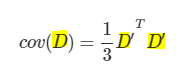

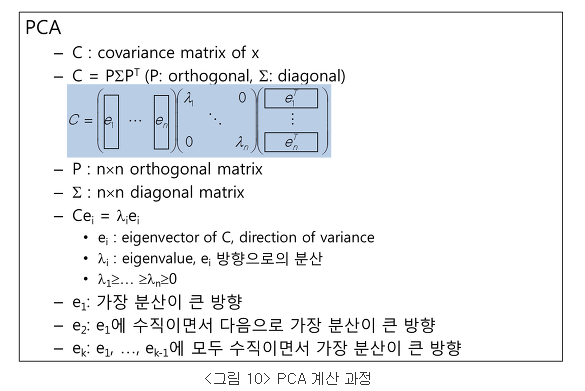

상기 식처럼 표현하면,  
`feature들의 공분산행렬`: __pca.get_covariance()__  
`공분산행렬의 eigen vector`: __pca.components___    
`공분산행렬의 eigen value`: __pca.explained_variance___    

In [34]:
## feature들의 공분산행렬
print("feature 100개를 공분산행렬A이라 할때\n A Covariance(): shape{}".format(pca.get_covariance().shape))
print(" A행렬의 고유벡터(eigen vactor) 행렬 P: {}".format(pca.components_.shape))
print(" A행렬의 고유치(eigen value) 대각행렬 lambda diag: {}".format(np.diag(pca.explained_variance_).shape))

feature 100개를 공분산행렬A이라 할때
 A Covariance(): shape(100, 100)
 A행렬의 고유벡터(eigen vactor) 행렬 P: (10, 100)
 A행렬의 고유치(eigen value) 대각행렬 lambda diag: (10, 10)


In [18]:
## 실제결과 비교하기
print(pca.get_covariance()[0][0:5])

tmp = np.dot(pca.components_.T,np.diag(pca.explained_variance_))
rslt = np.dot(tmp,pca.components_)

print(rslt[0][0:5])

[ 1.11111111 -1.10744082  0.81218567 -1.10384724  1.10750806]
[ 1.11111111 -1.10744082  0.81218567 -1.10384724  1.10750806]


## Draw a scree plot and a PCA plot

`여기서 얻어지는 pca_data 는 각각의 주성분사용하여, 원래 데이터를 선형변환한 값이다.`

In [19]:
#The following code constructs the Scree plot
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

In [32]:
["{:.3f}".format(x) for x in list(pca.explained_variance_)]

['99.991',
 '2.829',
 '2.138',
 '1.775',
 '1.449',
 '0.921',
 '0.906',
 '0.646',
 '0.456',
 '0.000']

In [20]:
per_var

array([90. ,  2.5,  1.9,  1.6,  1.3,  0.8,  0.8,  0.6,  0.4,  0. ])

In [21]:
labels

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']

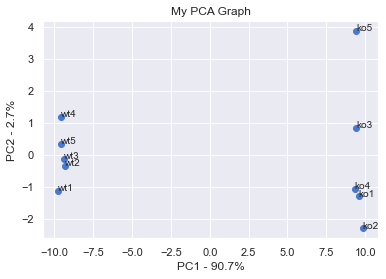

In [31]:
#the following code makes a fancy looking plot using PC1 and PC2
pca_df = pd.DataFrame(pca_data, index=[*wt, *ko], columns=labels)
 
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

In [32]:
pca_df

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
wt1 -9.738790 -1.116624  2.091364  0.645740  1.807849  0.708030 -0.945371   
wt2 -9.338353 -0.334183 -1.739749 -0.267985  0.497019 -1.339675 -0.685861   
wt3 -9.372304 -0.121915  0.154065 -1.823736 -1.718320  0.649251 -0.227509   
wt4 -9.561650  1.182604 -0.802338  1.780499 -1.264571  1.220643  0.207324   
wt5 -9.596711  0.334801  0.296172 -0.367832  0.622140 -1.255694  1.666176   
ko1  9.593789 -1.291382 -0.966927 -0.972139  1.152780  1.424507  1.224002   
ko2  9.849577 -2.297817  1.712944 -0.036669 -1.580440 -0.762954  0.060526   
ko3  9.437801  0.834536  0.086649  2.317598 -0.073271 -0.435030  0.347616   
ko4  9.319239 -1.062816 -1.714125 -0.018751  0.197681 -0.133347 -1.153286   
ko5  9.407403  3.872795  0.881945 -1.256724  0.359133 -0.075731 -0.493618   

          PC8       PC9          PC10  
wt1  0.090597  0.021218  2.470246e-15  
wt2 -1.019471  0.391207  7.216450e-16  
wt3  0.615266  0.788255  2.220446e-16  
wt4 -0.394909 -0.694637  1.665335e-16  
wt5  0.677560 -0.495294 -5.828671e-16  
ko1 -0.475515  0.199123 -4.440892e-16  
ko2 -0.607932 -0.387206 -8.881784e-16  
ko3  0.387848  1.054353 -1.110223e-16  
ko4  1.027797 -0.632521  7.216450e-16  
ko5 -0.301242 -0.244500  1.110223e-16

## 총분산으로 비율 확인하기

In [146]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

In [147]:
print(per_var.sum())
per_var ## 총분산값을 보여준다.
## 순서데로, PC1의 요소의 Var 값이다.

100.00000000000001


array([88.9,  2.8,  2.2,  1.7,  1.4,  1.2,  0.8,  0.6,  0.4,  0. ])

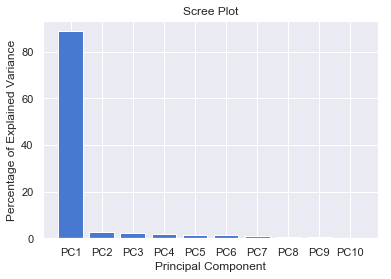

In [148]:
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()
 

## Determine which genes had the biggest influence on PC1

In [149]:
pca.components_.shape

(10, 100)

In [150]:
## get the name of the top 10 measurements (genes) that contribute
## most to pc1.
## first, get the loading scores
loading_scores = pd.Series(pca.components_[0], index=genes) ## pca.components_[0] 첫번째 고유벡터
## now sort the loading scores based on their magnitude
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
 
# get the names of the top 10 genes
top_10_genes = sorted_loading_scores[0:10].index.values
 
## print the gene names and their scores (and +/- sign)
print(loading_scores[top_10_genes])

gene96   -0.106024
gene97    0.106020
gene10    0.106018
gene79    0.106002
gene49   -0.105999
gene51    0.105978
gene73    0.105965
gene18   -0.105957
gene59   -0.105953
gene38   -0.105941
dtype: float64


위 결과에서 보면, 특정한 cell 이 PC1의 구성에 큰 영향을 주는 상태가 아니라, 모두 일정하게 영향을 주고 있는 것으로 보인다. 즉, 특별한 cell 이 영향을 미친다고 할 수 없다.

## Special PCA
random.poisson 은 lam 다 값을 통하여, 랜덤하게 값을 뽑는데, 이때 lambda의 범위를 10 ~ 1000 으로 한다.  
이걸 활용하여, 이 lambda 값을 활용하여, 포아송 분포에서, 랜덤하게 5(size=5)개를 추출한다. 

In [61]:
x1=np.array([1,2,1]).reshape(3,1)
x2=np.array([4,2,13]).reshape(3,1)
x3=np.array([7,8,1]).reshape(3,1)
x4=np.array([8,4,5]).reshape(3,1)
X=np.c_[x1,x2,x3,x4];X

array([[ 1,  4,  7,  8],
       [ 2,  2,  8,  4],
       [ 1, 13,  1,  5]])

## SVD (sigular Value Decomposition)

지금까지의 내용으로 PCA 는 data-feature 들의 공분산을 eigien-decomposition 하는 것을 알았다.  
그러나, PCA doc 에서는 svd 옵션이 계속 언급되어 의아하다.  
실제로 PCA 파라미터 중 solcer='FULL' 선택시 scipy-linalg 라이브러리의 SVD를 활용한다고 되어 있어서, 실제로 수행비교해본다.

In [134]:
from scipy import linalg

* `U` : Unitary matrix having left singular vectors as columns. Of shape (M, M) or (M, K), depending on full_matrices.

* `s` : The singular values, sorted in non-increasing order. Of shape (K,), with K = min(M, N).

* `Vh` : Unitary matrix having right singular vectors as rows. Of shape (N, N) or (K, N) depending on full_matrices.

In [135]:
print(pca.get_covariance().shape)
test_svd = pca.get_covariance()

(100, 100)


In [136]:
U, s, Vh = linalg.svd(test_svd)
U.shape,  s.shape, Vh.shape

((100, 100), (100,), (100, 100))

In [176]:
print("feature 100개를 공분산행렬A이라 할때\n A Covariance(): shape{}".format(pca.get_covariance().shape))
print(" A행렬의 고유벡터(eigen vactor) 행렬 P: {}".format(pca.components_.shape))
print(" A행렬의 고유치(eigen value) 대각행렬 P: {}".format(np.diag(pca.explained_variance_).shape))

feature 100개를 공분산행렬A이라 할때
 A Covariance(): shape(100, 100)
 A행렬의 고유벡터(eigen vactor) 행렬 P: (10, 100)
 A행렬의 고유치(eigen value) 대각행렬 P: (10, 10)


In [181]:
len(pca.explained_variance_),'vs',len(s)

(10, 'vs', 100)

In [187]:
np.round(pca.explained_variance_,6)[8:],'vs',np.round(s,6)[8:14]

(array([0.416716, 0.      ]),
 'vs',
 array([0.416716, 0.      , 0.      , 0.      , 0.      , 0.      ]))

고유값행렬이 길이가 차이가 난다. -> 이는 PCA 에서, n_component param 값에 10 이 자동으로 들어갔기 때문이다.

In [144]:
pca.components_[0,0:3]

array([-0.105073  ,  0.10451952,  0.10492748])

In [173]:
Vh[0,0:3]

array([-0.105073  ,  0.10451952,  0.10492748])

In [201]:
(np.round(U.T,0)==np.round(Vh,0)).sum()
## 소숫점차이로 정확하지는 핞으나 100 by 100 10000 개 가 거의 일히한다고 볼 수 있다.

9989

**SVD와 PCA는 유사점**  
- 둘 다, eigen-decomposition 을 기반으로 한다.  
- feature 공분산 을 eigen-decomposition 하는 것이 PCA  
- singular-value-decomposition 은 컨셉을 따라가면, 결국 PCA 결과와 완전 동일한다. 아래 증명참조!!  
[SVD 와 PCA](https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/04/06/pcasvdlsa/)  

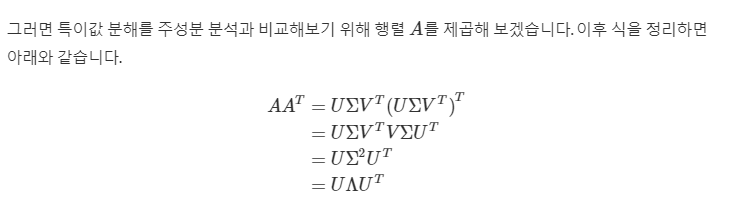